In [ ]:
!pip install transformers
!pip install -q git+https://github.com/gmihaila/ml_things.git
!pip install matplotlib==3.1.3

     |████████████████████████████████| 2.1MB 7.2MB/s 
     |████████████████████████████████| 3.3MB 37.7MB/s 
     |████████████████████████████████| 901kB 55.3MB/s 
     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 10.3MB 10.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 13.1MB 243kB/s 
ERROR: ml-things 0.0.1 has requirement matplotlib>=3.4.0, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.4.1
    Uninstalling matplotlib-3.4.1:
      Successfully uninstalled matplotlib-3.4.1


# Imports and hyperparameters

In [ ]:
import io 
import os 
import torch
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

set_seed(123)

epochs = 3

batch_size = 64


max_length = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name_or_path = 'gpt2'



/usr/local/lib/python3.7/dist-packages/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


In [ ]:
device

device(type='cuda')

# Helper functions

In [ ]:
"""
Most of the source code is taken from
https://www.drivendata.co/blog/hateful-memes-benchmark/
"""
from torch.utils.data import Dataset
import pandas as pd
import torch
from PIL import Image


class HatefulMemesDataset(Dataset):

    def __init__(self, jsonl_path):
        """
        :param jsonl_path: path to jsonl provided by Facebook (e.g. data/train.jsonl
        :param path_to_img_dir: path to parent directory of img dir
        :param image_transform: torchvision.transforms.Compose
        :param text_transform: (texts: Union[str, List[str]]) -> torch.LongTensor
        """
        self.samples_frame = pd.read_json(jsonl_path, lines=True)
        self.samples_frame = self.samples_frame.reset_index(drop=True)

    def __len__(self):
        return len(self.samples_frame)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      # TODO: Find a better way for reducing length of a sentence.
      # this is an actual sentence from the dataset:
      #
      # we only want to make you register them, restrict transfers, 
      # ban certain guns, limit magazine capacity, prohibit carrying them, 
      # ban or limit ammo, make other arbitrary laws, and, if we catch you 
      # violating any of these made-up rules, throw you in prison.... at 
      # which point we will take your guns!

      text = self.samples_frame.loc[idx, "text"]

      # case: development
      if "label" in self.samples_frame.columns:
          label = torch.Tensor(
              [self.samples_frame.loc[idx, "label"]]
          ).long().squeeze()
          sample = {
              "text": text,
              "label": label
          }
      else:
          # case: inference
          sample = {
              "text": text
          }

        return sample


class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

        return


    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]        
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)

        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_, epoch):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader),  desc=f"Epoch {epoch}", position=1):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []

  predicted_probs = []

  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, desc='Val', total=len(dataloader), position=2):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]

        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        predicted_probs.append(probs)
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()


        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  predicted_probs = np.concatenate(predicted_probs, axis=0)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss, predicted_probs


# Load model and tokenizer

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=2)


# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))


# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id


# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...



Loading tokenizer...



Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


# Dataset and Collator

In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          max_sequence_len=max_length)

print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = HatefulMemesDataset(jsonl_path='train.jsonl')
print('Created `train_dataset` with %d examples!'%len(train_dataset))
# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  HatefulMemesDataset(jsonl_path='dev_all.jsonl')
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 8500 examples!
Created `train_dataloader` with 133 batches!


Dealing with Validation...
Created `valid_dataset` with 640 examples!
Created `eval_dataloader` with 10 batches!


# Train


  train_loss: 0.64960 - val_loss: 0.70616 - train_acc: 0.64494 - valid_acc: 0.63750




  train_loss: 0.59381 - val_loss: 0.71363 - train_acc: 0.69471 - valid_acc: 0.62813




  train_loss: 0.55656 - val_loss: 0.72477 - train_acc: 0.72365 - valid_acc: 0.62031




/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


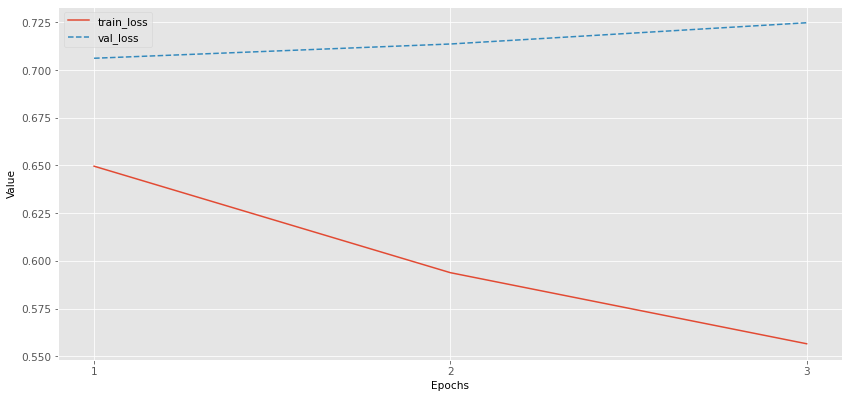

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


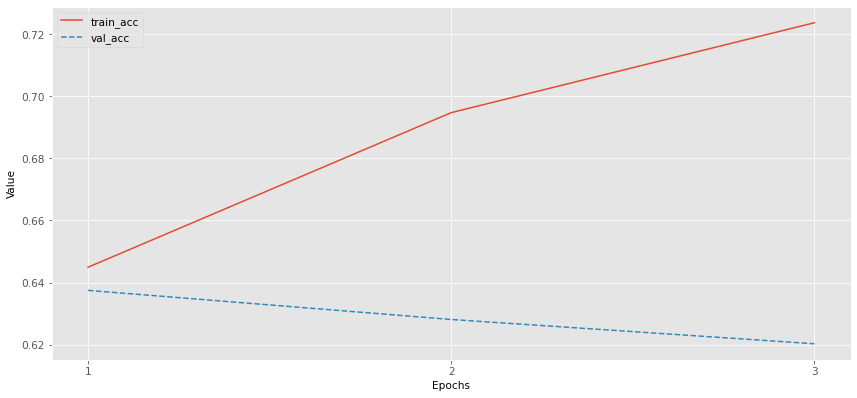

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs



# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}\


# Loop through each epoch.
for epoch in tqdm(range(epochs), desc='Total Epochs', position=0):
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device, epoch)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  valid_labels, valid_predict, val_loss, _ = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print() 

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)



# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Evaluation


(640, 2)
640
              precision    recall  f1-score   support

 Non-Hateful       0.65      0.83      0.73       393
     Hateful       0.51      0.29      0.37       247

    accuracy                           0.62       640
   macro avg       0.58      0.56      0.55       640
weighted avg       0.60      0.62      0.59       640

Normalized confusion matrix


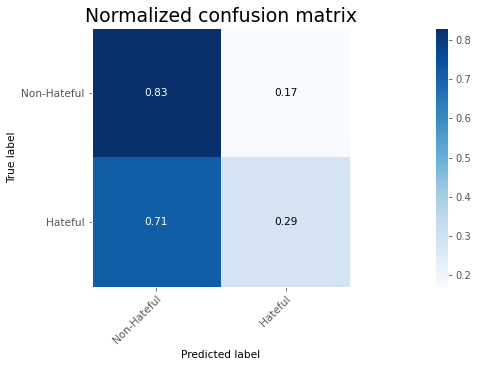

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss, predicted_probs = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=[0, 1], target_names=['Non-Hateful', 'Hateful'])
print(predicted_probs.shape)
print(len(true_labels))
au_roc = roc_auc_score(true_labels, predicted_probs[:, 1])
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=['Non-Hateful', 'Hateful'], normalize=True, 
                      magnify=0.1,
                      );


In [ ]:
import numpy as np

def aucroc(probs, labels):
    """
    Given predicted probabilities and labels, returns the AUCROC score used in the Facebook Meme Challenge.
    Inputs are expected to be pytorch tensors (can be cuda or cpu)
    """
    if isinstance(probs, torch.Tensor):
        probs = probs.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    assert np.all(np.logical_and(probs <= 1.0, probs >= 0.0)), "Probabilities must be between 0 and 1"
    assert np.all(np.logical_or(labels == 0, labels == 1)), "Labels must be binary (0 or 1)"
    if not (np.any(labels == 0) and np.any(labels == 1)):
        LOGGER.warning("ROC AUC calculation got only one label. Score not defined here, setting it to 0.")
        return 0.0
    
    aucroc_score = roc_auc_score(y_true=labels, y_score=probs[:, 1], average='macro')
    return aucroc_score

In [ ]:
aucroc(predicted_probs, np.array(true_labels))

0.5860555675742498

In [ ]:
true_labels